In [1]:
# Build list of forecast file names for a date range and a specific time (HHMM) 
import os, re
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- USER INPUTS ---
start_date = "2025-08-31"   # 'YYYY-MM-DD' or 'YYYYMMDD' (inclusive)
end_date   = "2025-09-30"   # 'YYYY-MM-DD' or 'YYYYMMDD' (inclusive)
time_str   = "1100"         # 'HHMM' e.g. '0100', '0115', '2300'

# --- Build list ---
# Normalize dates with pandas
start = pd.to_datetime(start_date)
end = pd.to_datetime(end_date)

# Validate the time format
if not (isinstance(time_str, str) and len(time_str) == 4 and time_str.isdigit()):
    raise ValueError("time_str must be a string in 'HHMM' format, e.g. '0100' or '1115'.")

# Generate daily dates (inclusive)
dates = pd.date_range(start=start, end=end, freq="D")

# Create file names
names = [f"forecast_{d.strftime('%Y%m%d')}{time_str}.csv" for d in dates]

file_list_df = pd.DataFrame({"filename": names})

# Show results
print(names)           # Python list
file_list_df           # Pandas DataFrame view


['forecast_202508311100.csv', 'forecast_202509011100.csv', 'forecast_202509021100.csv', 'forecast_202509031100.csv', 'forecast_202509041100.csv', 'forecast_202509051100.csv', 'forecast_202509061100.csv', 'forecast_202509071100.csv', 'forecast_202509081100.csv', 'forecast_202509091100.csv', 'forecast_202509101100.csv', 'forecast_202509111100.csv', 'forecast_202509121100.csv', 'forecast_202509131100.csv', 'forecast_202509141100.csv', 'forecast_202509151100.csv', 'forecast_202509161100.csv', 'forecast_202509171100.csv', 'forecast_202509181100.csv', 'forecast_202509191100.csv', 'forecast_202509201100.csv', 'forecast_202509211100.csv', 'forecast_202509221100.csv', 'forecast_202509231100.csv', 'forecast_202509241100.csv', 'forecast_202509251100.csv', 'forecast_202509261100.csv', 'forecast_202509271100.csv', 'forecast_202509281100.csv', 'forecast_202509291100.csv', 'forecast_202509301100.csv']


,filename
0,forecast_202508311100.csv
1,forecast_202509011100.csv
2,forecast_202509021100.csv
3,forecast_202509031100.csv
4,forecast_202509041100.csv
5,forecast_202509051100.csv
6,forecast_202509061100.csv
7,forecast_202509071100.csv
8,forecast_202509081100.csv
9,forecast_202509091100.csv


In [2]:
# ===================== PATHS =====================
ACTUALS_CSV = "/home/renga/Desktop/neoen_data/renga_work/data/measurements_neoen_morcenx_sep2025.csv"      # actuals (kW @ 15-min)
PRICES_CSV  = "/home/renga/Desktop/neoen_data/renga_work/data/grid_penalty/combined_with_utc.csv"             # has measure_date, da_price, Long, Short
FC_DIR      = Path("/home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx")                     # forecast directory

GRID_STATE = Path("/home/renga/Desktop/neoen_data/renga_work/outputs_same_tod/predicted_grid_state.csv")  # predicted grid state 



In [3]:
# Actuals
ACT_TIME_COL = "measure_date"    # UTC tz-aware
ACT_PROD_COL = "prod"            # kW over the 15-min block

# Prices
PRICE_TIME_COL   = "measure_date"  # UTC tz-aware
PRICE_DA_COL     = "da_price_15min"      # EUR/MWh (hourly or 15-min; we'll FFILL to quarters)
PRICE_LONG_COL   = "Long"          # EUR/MWh for overproduction (15-min)
PRICE_SHORT_COL  = "Short"         # EUR/MWh for underproduction (15-min)

# Forecasts 
FC_TARGET_COL = "horizon"          # tz-aware UTC timestamps of the target quarters
FC_DET_COL    = "deterministic"
FC_CLEAR_COL  = "clear_sky"
FC_TS_REGEX   = re.compile(r"forecast_(\d{12})\.csv")   # extract run timestamp from filename
FC_QUANT_COLS = [
    "p_05","p_10","p_15","p_20","p_25","p_30","p_35","p_40","p_45",
    "p_50","p_55","p_60","p_65","p_70","p_75","p_80","p_85","p_90","p_95"
 ]

# Units: kW @ 15-min → MWh
KW_TO_MWH_QUARTER = 1.0 / (1000.0 * 4.0)  # 0.00025

In [4]:
# Helper functions reused across runs
ACTUALS_CACHE = None
PRICES_CACHE = None

def normalize_p_selection(p_selection):
    """Accept 10, 'p_10', [10,50,90], etc., and return matching p_* column names."""
    if p_selection is None:
        return []
    def to_col(val):
        s = str(val).strip().lower()
        if s.startswith("p_"):
            return s
        if s.startswith("p"):
            return "p_" + s[1:].zfill(2)
        if s.replace(".", "", 1).isdigit():
            return f"p_{int(float(s)):02d}"
        return None
    choices = [p_selection] if not isinstance(p_selection, (list, tuple, set)) else list(p_selection)
    cols = []
    for val in choices:
        col = to_col(val)
        if col in FC_QUANT_COLS and col not in cols:
            cols.append(col)
    return cols

def load_inputs(refresh: bool = False):
    """Load (and cache) actuals and price tables."""
    global ACTUALS_CACHE, PRICES_CACHE
    if refresh or ACTUALS_CACHE is None or PRICES_CACHE is None:
        actuals = pd.read_csv(ACTUALS_CSV, parse_dates=[ACT_TIME_COL])
        if actuals[ACT_TIME_COL].dtype.tz is None:
            actuals[ACT_TIME_COL] = actuals[ACT_TIME_COL].dt.tz_localize("UTC")
        mask_15 = (actuals[ACT_TIME_COL].dt.minute % 15 == 0) & (actuals[ACT_TIME_COL].dt.second == 0)
        actuals = actuals.loc[mask_15, [ACT_TIME_COL, ACT_PROD_COL]].sort_values(ACT_TIME_COL).reset_index(drop=True)

        prices = pd.read_csv(PRICES_CSV, parse_dates=[PRICE_TIME_COL])
        if prices[PRICE_TIME_COL].dtype.tz is None:
            prices[PRICE_TIME_COL] = prices[PRICE_TIME_COL].dt.tz_localize("UTC")
        prices = prices[[PRICE_TIME_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]].sort_values(PRICE_TIME_COL)
        for col in [PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL]:
            if col in prices.columns:
                prices[col] = pd.to_numeric(prices[col], errors="coerce")
        prices = prices.set_index(PRICE_TIME_COL).sort_index()
        if PRICE_DA_COL in prices.columns:
            prices[PRICE_DA_COL] = prices[PRICE_DA_COL].ffill()
        prices = prices.reset_index()

        ACTUALS_CACHE, PRICES_CACHE = actuals, prices
    return ACTUALS_CACHE.copy(), PRICES_CACHE.copy()

def run_time_to_path(run_ts_utc: pd.Timestamp) -> Path:
    return FC_DIR / f"forecast_{run_ts_utc.tz_convert('UTC').strftime('%Y%m%d%H%M')}.csv"

def load_forecast_run(run_time_str: str, p_selection=None, include_det=True, include_clear=False):
    run_ts = pd.Timestamp(datetime.strptime(run_time_str, "%Y%m%d%H%M"), tz="UTC")
    fpath = run_time_to_path(run_ts)
    if not fpath.exists():
        raise FileNotFoundError(f"Missing forecast file: {fpath}")

    cols = [FC_TARGET_COL]
    if include_det:
        cols.append(FC_DET_COL)
    if include_clear:
        cols.append(FC_CLEAR_COL)
    cols += normalize_p_selection(p_selection)

    fc = pd.read_csv(fpath, parse_dates=[FC_TARGET_COL], usecols=cols)
    if fc[FC_TARGET_COL].dtype.tz is None:
        fc[FC_TARGET_COL] = fc[FC_TARGET_COL].dt.tz_localize("UTC")
    fc = fc.sort_values(FC_TARGET_COL).reset_index(drop=True)
    fc["run_time"] = run_ts
    fc["lead_hours"] = (fc[FC_TARGET_COL] - run_ts).dt.total_seconds() / 3600.0
    return fc, run_ts, fpath

def build_run_ledger(run_time_str: str, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    actuals, prices = load_inputs()
    fc, run_ts, fpath = load_forecast_run(run_time_str, p_selection, include_det, include_clear)

    merged = (fc
              .merge(actuals, left_on=FC_TARGET_COL, right_on=ACT_TIME_COL, how="inner")
              .merge(prices, left_on=FC_TARGET_COL, right_on=PRICE_TIME_COL, how="left"))

    selected_fc_cols = []
    if include_det and FC_DET_COL in merged.columns:
        selected_fc_cols.append(FC_DET_COL)
    if include_clear and FC_CLEAR_COL in merged.columns:
        selected_fc_cols.append(FC_CLEAR_COL)
    selected_fc_cols += [c for c in normalize_p_selection(p_selection) if c in merged.columns]

    for col in [ACT_PROD_COL, PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols:
        if col in merged.columns:
            merged[col] = pd.to_numeric(merged[col], errors="coerce")

    if strategy_spec is not None:
        column_name = strategy_spec.get("column_name", "str_1")
        lower_col = strategy_spec.get("lower")
        upper_col = strategy_spec.get("upper")
        grid_state_path = strategy_spec.get("grid_state_path")
        if not all([column_name, lower_col, upper_col, grid_state_path]):
            raise ValueError("strategy_spec must include column_name, lower, upper, and grid_state_path")
        for col in (lower_col, upper_col):
            if col not in merged.columns:
                raise KeyError(f"Required quantile column '{col}' missing from merged forecast data.")
        grid_state = pd.read_csv(grid_state_path, parse_dates=["target_ts"])
        if grid_state["target_ts"].dtype.tz is None:
            grid_state["target_ts"] = grid_state["target_ts"].dt.tz_localize("UTC")
        grid_state = (grid_state
                       .rename(columns={"target_ts": "target_time"})
                       .drop_duplicates(subset=["target_time"], keep="last")
                       [["target_time", "pred_state"]])
        if "target_time" not in merged.columns:
            merged["target_time"] = merged[FC_TARGET_COL]
        merged = merged.merge(grid_state, on="target_time", how="left")
        if merged["pred_state"].isna().all():
            raise ValueError("pred_state is missing after merging grid state data." )
        merged[column_name] = np.where(
            merged["pred_state"] < 0, merged[lower_col],
            np.where(
                merged["pred_state"] > 0, merged[upper_col], 0.5 * (merged[lower_col] + merged[upper_col])
)
        )
        merged[column_name] = pd.to_numeric(merged[column_name], errors="coerce")
        selected_fc_cols.append(column_name)

    merged["actual_MWh"] = merged[ACT_PROD_COL] * KW_TO_MWH_QUARTER
    merged["revenue_EUR"] = merged["actual_MWh"] * merged[PRICE_DA_COL]

    long_df = (merged[[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                     PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL] + selected_fc_cols]
               .melt(id_vars=[FC_TARGET_COL, "run_time", "lead_hours", "actual_MWh", ACT_PROD_COL,
                             PRICE_DA_COL, PRICE_LONG_COL, PRICE_SHORT_COL],
                     var_name="forecast_col", value_name="forecast_kW")
               .rename(columns={FC_TARGET_COL: "target_time"}))
    long_df["forecast_MWh"] = long_df["forecast_kW"] * KW_TO_MWH_QUARTER
    long_df["forecast_type"] = (long_df["forecast_col"]
                                  .str.replace("p_", "p", regex=False)
                                  .mask(long_df["forecast_col"].eq(FC_DET_COL), "deterministic")
                                  .mask(long_df["forecast_col"].eq(FC_CLEAR_COL), "clear_sky"))
    long_df["delta_MWh"] = long_df["actual_MWh"] - long_df["forecast_MWh"]
    long_df["applied_price_EUR_per_MWh"] = np.where(long_df["delta_MWh"] > 0,
                                                     long_df[PRICE_LONG_COL],
                                                     long_df[PRICE_SHORT_COL])
    long_df["penalty_EUR"] = long_df["delta_MWh"] * long_df["applied_price_EUR_per_MWh"]

    long_df = long_df.merge(merged[[FC_TARGET_COL, "revenue_EUR"]].rename(columns={FC_TARGET_COL: "target_time"}),
                             on="target_time", how="left")
    long_df["net_revenue_EUR"] = long_df["revenue_EUR"] + long_df["penalty_EUR"]
    long_df = long_df[["run_time","target_time","lead_hours","forecast_type","actual_MWh","forecast_MWh",
                       "delta_MWh", PRICE_DA_COL,"revenue_EUR","applied_price_EUR_per_MWh","penalty_EUR",
                       "net_revenue_EUR"]].sort_values(["run_time","forecast_type","target_time"]).reset_index(drop=True)

    summary = (long_df.groupby("forecast_type", as_index=False)
               .agg(
                   n_15min=("net_revenue_EUR","size"),
                   total_revenue_EUR=("revenue_EUR","sum"),
                   total_penalty_EUR=("penalty_EUR","sum"),
                   total_net_EUR=("net_revenue_EUR","sum"),
                   mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                   rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
               .sort_values("total_net_EUR", ascending=False))
    return long_df, summary, fpath, run_ts

def build_ledgers_for_runs(file_df: pd.DataFrame, p_selection=None, include_det=True, include_clear=False, strategy_spec: dict | None = None):
    """Loop over multiple forecast files and return combined ledger + per-run + cumulative summaries."""
    if isinstance(file_df, pd.DataFrame):
        filenames = file_df["filename"].tolist()
    else:
        filenames = list(file_df)
    all_ledgers = []
    all_summaries = []
    skipped = []
    for fname in filenames:
        name = Path(fname).name
        match = FC_TS_REGEX.search(name)
        if not match:
            skipped.append((fname, "pattern mismatch"))
            continue
        run_time_str = match.group(1)
        try:
            ledger, summary, fpath, run_ts = build_run_ledger(run_time_str, p_selection, include_det, include_clear, strategy_spec)
        except FileNotFoundError as exc:
            skipped.append((fname, str(exc)))
            continue
        ledger = ledger.copy()
        ledger["forecast_file"] = fpath.name
        summary = summary.copy()
        summary["forecast_file"] = fpath.name
        summary["run_time"] = run_ts
        all_ledgers.append(ledger)
        all_summaries.append(summary)
    if not all_ledgers:
        print("No forecast files processed.")
        if skipped:
            print("Skipped files:")
            for entry in skipped:
                print("  ", entry[0], "->", entry[1])
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), skipped
    combined_ledger = pd.concat(all_ledgers, ignore_index=True)
    per_run_summary = pd.concat(all_summaries, ignore_index=True)

    cumulative_summary = (combined_ledger.groupby("forecast_type", as_index=False)
                          .agg(
                              n_15min=("net_revenue_EUR","size"),
                              total_revenue_EUR=("revenue_EUR","sum"),
                              total_penalty_EUR=("penalty_EUR","sum"),
                              total_net_EUR=("net_revenue_EUR","sum"),
                              mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
                              rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
)
                          .sort_values("total_net_EUR", ascending=False))

    if skipped:
        print("Skipped files:")
        for entry in skipped:
            print("  ", entry[0], "->", entry[1])

    return combined_ledger, per_run_summary, cumulative_summary, skipped

In [5]:
# Parameters for multi-run processing
P_SELECTION  = [10,20,30,40,50,60,70,80,90]
INCLUDE_DET  = True
INCLUDE_CLEAR= False
STRATEGY_SPEC = {
    "column_name": "str_1",
    "lower": "p_40",
    "upper": "p_60",
    "grid_state_path": GRID_STATE
}

combined_ledger, per_run_summary, cumulative_summary, skipped_files = build_ledgers_for_runs(
    file_list_df,
    p_selection=P_SELECTION,
    include_det=INCLUDE_DET,
    include_clear=INCLUDE_CLEAR,
    strategy_spec=STRATEGY_SPEC
)

print(f"Processed {len(per_run_summary['forecast_file'].unique()) if not per_run_summary.empty else 0} forecast runs")
if skipped_files:
    print("\nSome files were skipped (see reasons above).")

print("\nPer-run summary (by forecast type and run):")
display(per_run_summary.sort_values(["run_time","forecast_type"]))

print("\nCumulative summary across all runs:")
display(cumulative_summary)

print("\nCombined ledger preview:")
display(combined_ledger.head())

/tmp/ipykernel_180738/54161515.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_180738/54161515.py:159: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
/tmp/ipykernel_180738/54161515.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_180738/54161515.py:159: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
/tmp/ipykernel_180738/54161515.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_180738/54161515.py:159: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))
/tmp/ipykernel_180738/54161515.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_180738/54161515.py:159: RuntimeWarning: Me

Skipped files:
   forecast_202508311100.csv -> Missing forecast file: /home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx/forecast_202508311100.csv
   forecast_202509181100.csv -> Missing forecast file: /home/renga/Desktop/data_neoen/data/forecast_neoen_morcenx/forecast_202509181100.csv
Processed 29 forecast runs

Some files were skipped (see reasons above).

Per-run summary (by forecast type and run):


/tmp/ipykernel_180738/54161515.py:158: RuntimeWarning: Mean of empty slice
  mae_MWh=("delta_MWh", lambda s: np.nanmean(np.abs(s))),
/tmp/ipykernel_180738/54161515.py:159: RuntimeWarning: Mean of empty slice
  rmse_MWh=("delta_MWh", lambda s: np.sqrt(np.nanmean(s**2)))


,forecast_type,n_15min,total_revenue_EUR,total_penalty_EUR,total_net_EUR,mae_MWh,rmse_MWh,forecast_file,run_time
5,deterministic,192,1163.429275,1093.588733,2256.315948,0.836971,1.192117,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
10,p10,192,1163.429275,-1109.748096,52.979119,0.684011,0.970932,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
9,p20,192,1163.429275,-682.780814,479.946401,0.684633,0.995178,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
8,p30,192,1163.429275,-285.765883,876.961332,0.725566,1.091384,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
7,p40,192,1163.429275,179.694862,1342.422077,0.777612,1.175856,forecast_202509011100.csv,2025-09-01 11:00:00+00:00
...,...,...,...,...,...,...,...,...,...
314,p60,51,0.000000,0.000000,0.000000,NaN,NaN,forecast_202509301100.csv,2025-09-30 11:00:00+00:00
315,p70,51,0.000000,0.000000,0.000000,NaN,NaN,forecast_202509301100.csv,2025-09-30 11:00:00+00:00
316,p80,51,0.000000,0.000000,0.000000,NaN,NaN,forecast_202509301100.csv,2025-09-30 11:00:00+00:00
317,p90,51,0.000000,0.000000,0.000000,NaN,NaN,forecast_202509301100.csv,2025-09-30 11:00:00+00:00



Cumulative summary across all runs:


,forecast_type,n_15min,total_revenue_EUR,total_penalty_EUR,total_net_EUR,mae_MWh,rmse_MWh
2,p20,5382,37061.964683,-615.671054,36436.148829,0.611689,0.960454
3,p30,5382,37061.964683,-868.939580,36182.880303,0.597206,0.975680
1,p10,5382,37061.964683,-1759.346760,35272.651021,0.668090,0.986527
4,p40,5382,37061.964683,-2467.999279,34583.820604,0.613021,1.004867
10,str_1,5382,37061.964683,-3091.272263,33960.547620,0.691985,1.099411
5,p50,5382,37061.964683,-4262.115493,32789.704390,0.647043,1.045106
0,deterministic,5382,37061.964683,-4432.853136,32618.966747,0.637465,1.014562
6,p60,5382,37061.964683,-5950.582201,31101.237683,0.704716,1.109544
7,p70,5382,37061.964683,-8153.649813,28898.170070,0.794354,1.202016
8,p80,5382,37061.964683,-11447.997793,25603.822090,0.941066,1.343645



Combined ledger preview:


,run_time,target_time,lead_hours,forecast_type,actual_MWh,forecast_MWh,delta_MWh,da_price_15min,revenue_EUR,applied_price_EUR_per_MWh,penalty_EUR,net_revenue_EUR,forecast_file
0,2025-09-01 11:00:00+00:00,2025-09-01 11:15:00+00:00,0.25,deterministic,1.692166,1.512338,0.179827,6.07,10.271446,-10.71,-1.925951,8.345495,forecast_202509011100.csv
1,2025-09-01 11:00:00+00:00,2025-09-01 11:30:00+00:00,0.50,deterministic,3.444361,2.458242,0.986120,6.07,20.907273,-10.71,-10.561341,10.345932,forecast_202509011100.csv
2,2025-09-01 11:00:00+00:00,2025-09-01 11:45:00+00:00,0.75,deterministic,0.724577,2.158441,-1.433863,6.07,4.398184,-9.79,14.037521,18.435705,forecast_202509011100.csv
3,2025-09-01 11:00:00+00:00,2025-09-01 12:00:00+00:00,1.00,deterministic,1.072843,2.248067,-1.175225,0.00,0.000000,51.38,-60.383037,-60.383037,forecast_202509011100.csv
4,2025-09-01 11:00:00+00:00,2025-09-01 12:15:00+00:00,1.25,deterministic,0.533908,2.114135,-1.580227,0.00,0.000000,-9.79,15.470426,15.470426,forecast_202509011100.csv


In [6]:
import matplotlib.ticker as mtick


def _ensure_utc(ts):
    if ts is None:
        return None
    t = pd.Timestamp(ts)
    return t.tz_localize("UTC") if t.tzinfo is None else t.tz_convert("UTC")


def plot_ledger_subset(ledger_subset: pd.DataFrame,
                       label: str,
                       start_ts=None,
                       end_ts=None,
                       selected_types=None,
                       aggregate_runs: bool = True) -> None:
    """Render stacked-bar + time-series plots for a ledger slice."""
    if ledger_subset.empty:
        print(f"{label}: no data available.")
        return

    data = ledger_subset.copy()
    start_ts = _ensure_utc(start_ts)
    end_ts = _ensure_utc(end_ts)
    if start_ts is not None:
        data = data[data["target_time"] >= start_ts]
    if end_ts is not None:
        data = data[data["target_time"] <= end_ts]
    if data.empty:
        print(f"{label}: no rows within the chosen time window.")
        return

    if selected_types:
        selected_types = [ft for ft in selected_types if ft in data["forecast_type"].unique()]
        if not selected_types:
            print(f"{label}: none of the requested forecast types are present.")
            return
        data = data[data["forecast_type"].isin(selected_types)]
    else:
        selected_types = sorted(data["forecast_type"].unique())

    data = data.sort_values(["forecast_type", "target_time"]).reset_index(drop=True)

    agg = (data.groupby("forecast_type", as_index=False)
              .agg(total_revenue_EUR=("revenue_EUR", "sum"),
                   total_penalty_EUR=("penalty_EUR", "sum"),
                   total_net_EUR=("net_revenue_EUR", "sum"),
                   n_15min=("net_revenue_EUR", "size")))

    det_net = np.nan
    if "deterministic" in agg["forecast_type"].values:
        det_net = float(agg.loc[agg["forecast_type"] == "deterministic", "total_net_EUR"].iloc[0])
    agg["pct_vs_det"] = np.nan
    if np.isfinite(det_net) and not np.isclose(det_net, 0.0):
        agg["pct_vs_det"] = (agg["total_net_EUR"] - det_net) / np.abs(det_net) * 100.0

    if ("str_1" in agg["forecast_type"].values) and np.isfinite(det_net) and det_net != 0:
        str_net = float(agg.loc[agg["forecast_type"] == "str_1", "total_net_EUR"].iloc[0])
        pct = float(agg.loc[agg["forecast_type"] == "str_1", "pct_vs_det"].iloc[0])
        print(f"{label}: deterministic total_net_EUR = {det_net:,.2f} €, str_1 = {str_net:,.2f} €, Δ = {pct:.2f}%")

    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(agg))
    # ---- Guideline at total Actual Revenue (same across forecast types for a given time window) ----
    rev_sum = float(np.nanmean(rev)) if len(rev) else np.nan
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    net_vals = agg["total_revenue_EUR"].to_numpy() + agg["total_penalty_EUR"].to_numpy()
    for xi, yi in zip(x, net_vals):
        ax.annotate(f"{yi:,.0f} €", xy=(xi, yi), xycoords="data", textcoords="offset points", xytext=(0, 4),
                    ha="center", va="bottom", fontsize=9)
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

    fig, ax1 = plt.subplots(figsize=(11, 4))
    if aggregate_runs:
        rev_series = (data.groupby("target_time", as_index=False)["revenue_EUR"].sum())
    else:
        rev_series = (data[["target_time", "revenue_EUR"]]
                        .drop_duplicates(subset=["target_time"], keep="last")
                        .sort_values("target_time"))
    ax1.plot(rev_series["target_time"], rev_series["revenue_EUR"], label="Revenue (actual)", linewidth=1.5)
    ax1.set_xlabel("Time (UTC)")
    ax1.set_ylabel("Revenue (€)")
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    cmap = plt.get_cmap("tab10", len(selected_types))
    for idx, ft in enumerate(selected_types):
        if aggregate_runs:
            s = (data.loc[data["forecast_type"] == ft]
                    .groupby("target_time", as_index=False)["penalty_EUR"].sum())
        else:
            s = (data.loc[data["forecast_type"] == ft, ["target_time", "penalty_EUR"]]
                    .sort_values("target_time"))
        ax2.plot(s["target_time"], s["penalty_EUR"], label=f"{ft} penalty", color=cmap(idx))

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1.02, 1.0), ncol=2, borderaxespad=0.0)
    ax2.set_ylabel("Penalty (€)")
    plt.title(f"Revenue (left) & Penalty (right) | {label}")
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()


All runs (cumulative): deterministic total_net_EUR = 32,618.97 €, str_1 = 33,960.55 €, Δ = 4.11%


NameError: name 'rev' is not defined

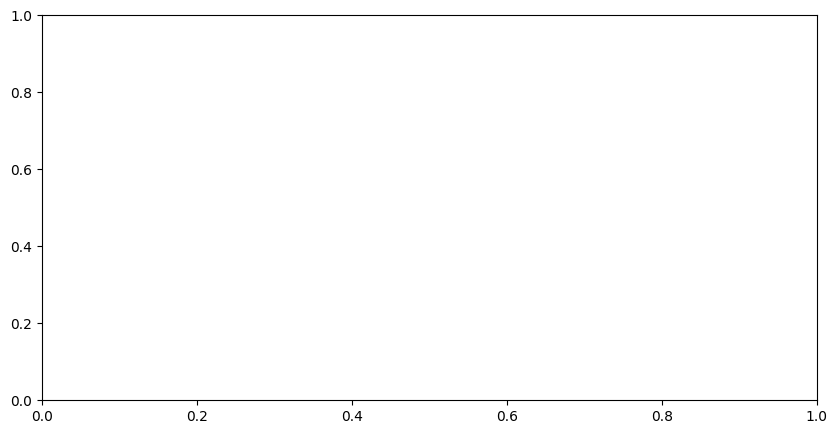

In [7]:
# ---- Graph generation across runs ----
# Adjust these parameters as needed
SELECTED_TYPES = ["deterministic", "p10", "p20", "p30", "p40", "p50", "p60", "p70", "p80", "p90", "str_1"]
START_TS = None   # e.g., "2025-09-07 00:00:00+00:00" or None
END_TS = None     # e.g., "2025-09-08 23:00:00+00:00" or None
RUNS_TO_PLOT = ["ALL"]  # use ["ALL"] for cumulative + every run; otherwise list forecast filenames
MAX_RUNS = None           # set to an integer to limit number of per-run plots

if combined_ledger.empty:
    print("combined_ledger is empty — run the build cell first.")
else:
    unique_runs = sorted(combined_ledger["forecast_file"].unique())

    if RUNS_TO_PLOT is None:
        runs_iter = []
        plot_all = False
    else:
        plot_all = "ALL" in RUNS_TO_PLOT or len(RUNS_TO_PLOT) == 0
        runs_iter = unique_runs if plot_all else [run for run in RUNS_TO_PLOT if run in unique_runs]

    if plot_all:
        plot_ledger_subset(combined_ledger, "All runs (cumulative)", start_ts=START_TS, end_ts=END_TS,
                           selected_types=SELECTED_TYPES, aggregate_runs=True)

    if MAX_RUNS is not None:
        runs_iter = runs_iter[:MAX_RUNS]

    for run_name in runs_iter:
        plot_ledger_subset(combined_ledger[combined_ledger["forecast_file"] == run_name],
                           f"Run {run_name}",
                           start_ts=START_TS,
                           end_ts=END_TS,
                           selected_types=SELECTED_TYPES,
                           aggregate_runs=False)
